In [4]:
!unzip /content/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: archive/images/TCGA_FG_A60K_20040224_4.tif  
  inflating: archive/images/TCGA_FG_A60K_20040224_40.tif  
  inflating: archive/images/TCGA_FG_A60K_20040224_41.tif  
  inflating: archive/images/TCGA_FG_A60K_20040224_42.tif  
  inflating: archive/images/TCGA_FG_A60K_20040224_43.tif  
  inflating: archive/images/TCGA_FG_A60K_20040224_44.tif  
  inflating: archive/images/TCGA_FG_A60K_20040224_45.tif  
  inflating: archive/images/TCGA_FG_A60K_20040224_46.tif  
  inflating: archive/images/TCGA_FG_A60K_20040224_47.tif  
  inflating: archive/images/TCGA_FG_A60K_20040224_48.tif  
  inflating: archive/images/TCGA_FG_A60K_20040224_49.tif  
  inflating: archive/images/TCGA_FG_A60K_20040224_5.tif  
  inflating: archive/images/TCGA_FG_A60K_20040224_50.tif  
  inflating: archive/images/TCGA_FG_A60K_20040224_51.tif  
  inflating: archive/images/TCGA_FG_A60K_20040224_52.tif  
  inflating: archive/images/TCGA_FG_A60K_20040224_53.tif  
  infla

#Image-preprocessing

**Image Preprocessing
We'll normalize the images, resize them to a fixed size (e.g., 128x128), and convert
them to grayscale**

In [5]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [6]:
# Load image and mask directories
image_dir = '/content/archive/images'
mask_dir = '/content/archive/masks'

In [29]:
from PIL import Image

def load_data(image_dir, mask_dir, img_size=(128, 128)):
    images = []
    masks = []

    for image_file in os.listdir(image_dir):
        img_path = os.path.join(image_dir, image_file)
        try:
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(img_size)
            images.append(np.array(img))
        except Exception as e:
            print(f"Warning: {image_file} could not be read. Error: {e}")
            continue

        # Load corresponding mask
        mask_file = image_file.replace('.tif', '_mask.tif')  # Adjust as needed
        mask_path = os.path.join(mask_dir, mask_file)
        try:
            mask = Image.open(mask_path).convert('L')  # Convert to grayscale
            mask = mask.resize(img_size)
            masks.append(np.array(mask))
        except Exception as e:
            print(f"Warning: {mask_file} could not be read. Error: {e}")
            continue

    images = np.array(images).reshape(-1, img_size[0], img_size[1], 1)
    masks = np.array(masks).reshape(-1, img_size[0], img_size[1], 1)

    return images, masks


In [30]:
# Load dataset
images, masks = load_data(image_dir, mask_dir)

In [31]:
# Normalize the images and masks
images = images / 255.0
masks = masks / 255.0

In [32]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2,
random_state=42)

##Step 3: U-Net Model for Image Segmentation
We’ll build a U-Net architecture, which is commonly used for medical image
segmentation due to its encoder-decoder structure that captures both low- and
high-level features.

In [33]:
from tensorflow.keras import layers, models
# U-Net model definition
def unet_model(input_size=(128, 128, 1)):
  inputs = layers.Input(input_size)
  # Encoder
  c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
  c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
  p1 = layers.MaxPooling2D((2, 2))(c1)
  c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
  c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
  p2 = layers.MaxPooling2D((2, 2))(c2)
  # Bottleneck
  c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
  c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
  # Decoder
  u2 = layers.UpSampling2D((2, 2))(c3)
  u2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
  u2 = layers.Concatenate()([u2, c2])
  c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
  c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
  u1 = layers.UpSampling2D((2, 2))(c4)
  u1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
  u1 = layers.Concatenate()([u1, c1])
  c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
  c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
  outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)
  model = models.Model(inputs=[inputs], outputs=[outputs])
  return model

In [34]:
# Create the model
model = unet_model()

In [35]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [36]:
# Print the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 64, 64, 256)    │              0 │ conv2d_5[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 128)    │        295,040 │ up_sampling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 256)    │              0 │ conv2d_6[0][0],        │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 128)    │        295,040 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 128, 128, 128)  │              0 │ conv2d_8[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 128, 128, 64)   │         73,792 │ up_sampling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 128, 128, 128)  │              0 │ conv2d_9[0][0],        │
│ (Concatenate)        

 Total params: 2,066,497 (7.88 MB)

 Trainable params: 2,066,497 (7.88 MB)

 Non-trainable params: 0 (0.00 B)

##Step 4: Training the Model
We will train the U-Net model using the MRI images and their corresponding tumor
masks.

Epoch 1/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 41s 151ms/step - accuracy: 0.9664 - loss: 0.1095 - val_accuracy: 0.9884 - val_loss: 0.0342
Epoch 2/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.9875 - loss: 0.0389 - val_accuracy: 0.9884 - val_loss: 0.0359
Epoch 3/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.9871 - loss: 0.0372 - val_accuracy: 0.9884 - val_loss: 0.0372
Epoch 4/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.9862 - loss: 0.0369 - val_accuracy: 0.9891 - val_loss: 0.0311
Epoch 5/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.9875 - loss: 0.0354 - val_accuracy: 0.9891 - val_loss: 0.0320
Epoch 6/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.9883 - loss: 0.0352 - val_accuracy: 0.9889 - val_loss: 0.0341
Epoch 7/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.9881 - loss: 0.0340 - val_accuracy: 0.9890 - val_loss: 0.0304
Epoch 8/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.9884 - loss: 0.0324 -

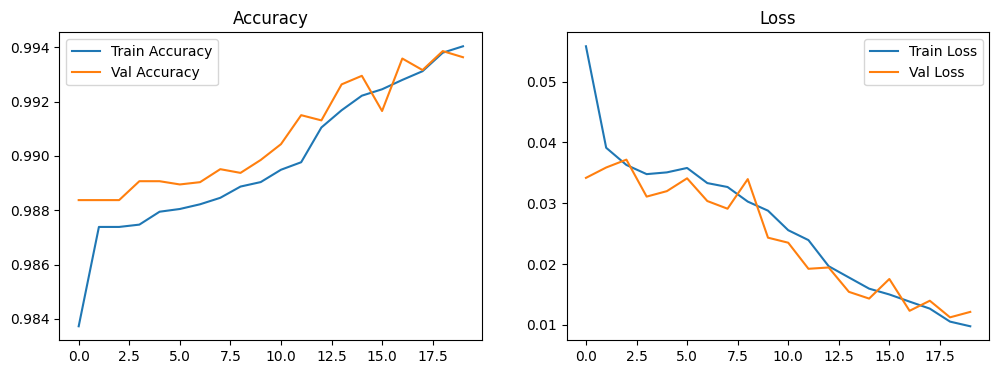

In [38]:
# Train the model

history = model.fit(X_train, y_train, validation_split=0.1, epochs=20, batch_size=16)



# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


#Step 5: Evaluation
Once trained, you can evaluate the model on the test data to see how well it performs
on tumor detection.

In [39]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - accuracy: 0.9939 - loss: 0.0118
Test accuracy: 0.9937


In [40]:
# Predict on test images
predictions = model.predict(X_test)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


In [41]:
# Threshold the predictions to create binary masks
predictions = (predictions > 0.5).astype(np.uint8)


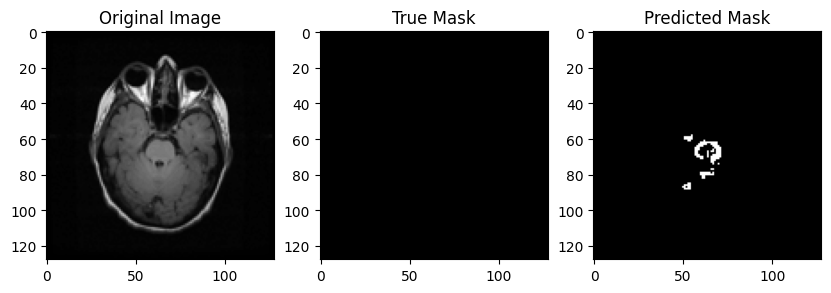

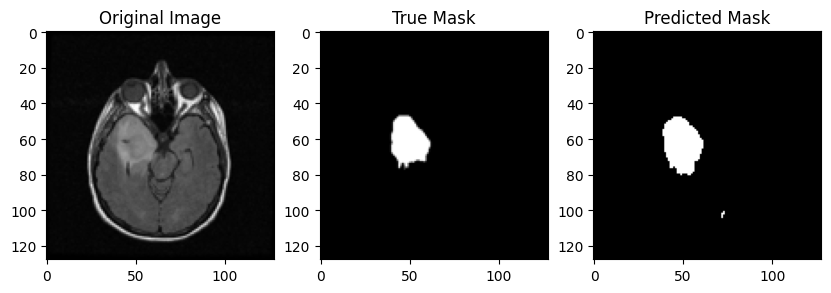

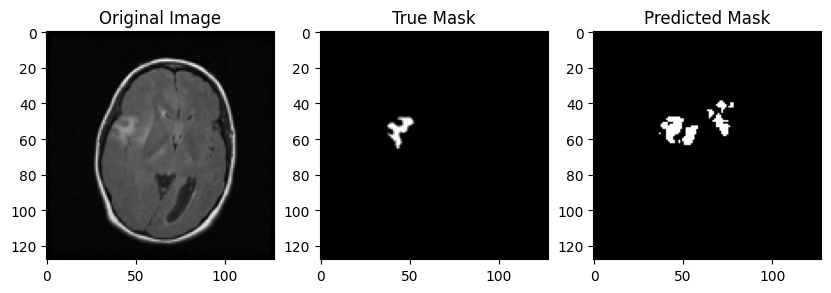

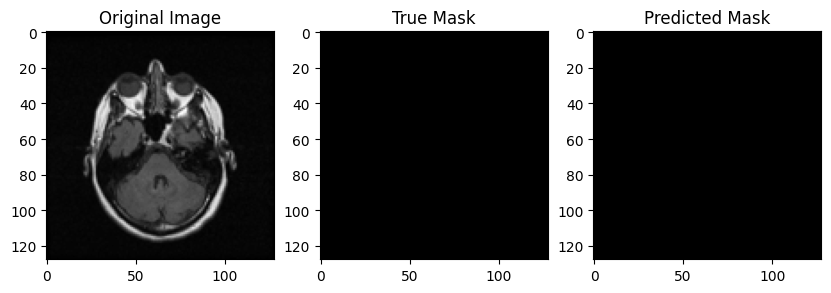

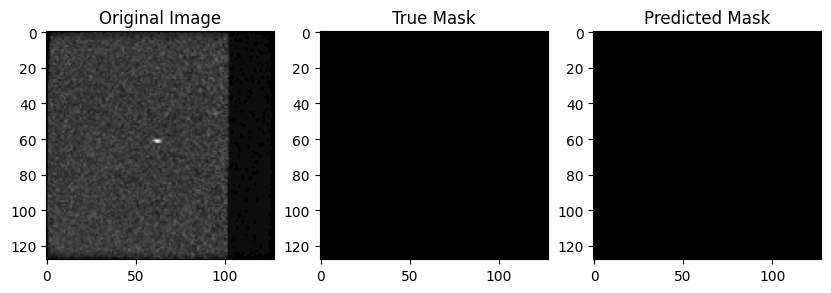

In [42]:
# Display some test images with their predicted masks
for i in range(5):
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 3, 1)
  plt.imshow(X_test[i].reshape(128, 128), cmap='gray')
  plt.title("Original Image")
  plt.subplot(1, 3, 2)
  plt.imshow(y_test[i].reshape(128, 128), cmap='gray')
  plt.title("True Mask")
  plt.subplot(1, 3, 3)
  plt.imshow(predictions[i].reshape(128, 128), cmap='gray')
  plt.title("Predicted Mask")
  plt.show()

##Step 6: Tumor Detection Output
The predicted mask will highlight the tumor region in the MRI image. You can overlay
the mask onto the original MRI image to visualize the detected tumor

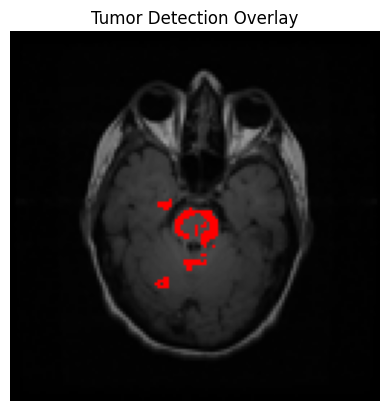

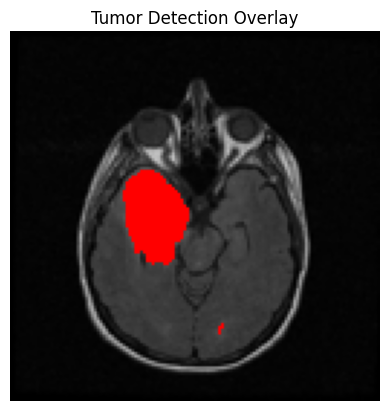

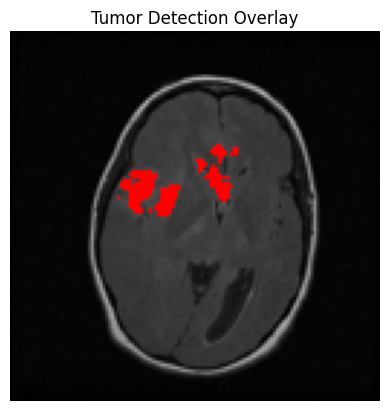

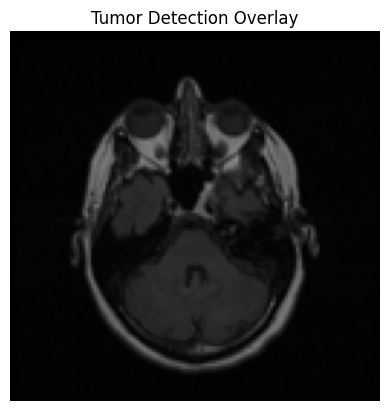

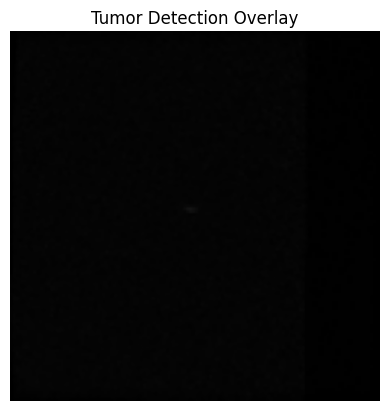

In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def overlay_mask(image, mask, alpha=0.5):
    """Overlay the mask on the image."""
    # Ensure the image is in the right format
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)  # Scale if needed

    # Convert the grayscale image to a 3-channel RGB image
    overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Ensure mask is binary and has the same size as the image
    mask = (mask > 0).astype(np.uint8)  # Convert to binary (0 or 1)

    if overlay.shape[:2] != mask.shape[:2]:  # Check if sizes match
        raise ValueError("Image and mask sizes do not match!")

    # Create an overlay where the mask is greater than 0
    overlay[mask > 0] = [0, 0, 255]  # Red color for the tumor region (BGR format)

    # Blend the original image with the overlay
    return cv2.addWeighted(overlay, alpha, overlay, 1 - alpha, 0)

# Show overlay of tumor mask on the original image
for i in range(5):
    img = X_test[i].reshape(128, 128)  # Reshape if needed
    mask = predictions[i].reshape(128, 128)  # Ensure mask is in the same shape

    overlay = overlay_mask(img, mask)

    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))  # Convert to RGB for display
    plt.title("Tumor Detection Overlay")
    plt.axis('off')  # Hide axes
    plt.show()
